# Carl Moser Report 4

License: Attribution 4.0 International (CC BY 4.0) 
https://creativecommons.org/licenses/by/4.0/

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from thinkbayes2 import Pmf, MakeWeibullPmf, EvalWeibullCdf, EvalWeibullPdf, EvalNormalPdf, Suite, Joint, Cdf
import thinkplot

### The Lightbulb problem
From https://github.com/AllenDowney/ThinkBayes2/blob/master/code/survival.ipynb

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

To begin this problem, we can define a lightbulb class that inherits from Suite and Joint. Since there are two parameters, we can either define our own init function or we can use product from itertools to send in the hypothesis. In this case, I chose to define my own init function that takes in an array of lams and ks. Next, we need to define the likelihood function. If lam=0, the likelihood will be zero and it will cause an error with evaluating the pdf so we can go ahead and return 0. If it is not zero, the likelihood is modeled by a weibull distribution so we can evaluate it with the lam and k of the hypothesis and the data.

In [2]:
class LightBulb(Suite, Joint):
    def __init__(self, lams, ks):
        
        tups = [(lam, k)
               for lam in lams
               for k in ks]
        
        Suite.__init__(self, tups)
        
    def Likelihood(self, data, hypo):
        x = data
        lam, k = hypo
        
        if lam == 0:
            return 0
        
        like = EvalWeibullPdf(x, lam, k)
        return like

In [3]:
# From the Survival Notebook
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

Now we can set up the lambdas and ks, use them to create a lightbulb object, and then update the object with our data.

In [4]:
lams = np.linspace(0,5,101)
ks = np.linspace(0,5,101)

bulb = LightBulb(lams,ks)
bulb.Update(1)

0.23110201243198006

Next, we can update the bulb with a random sample from a Weibull distribution use the function defined above.

In [5]:
lam = 2
k = 1.5
sample = SampleWeibull(lam, k, 10)
bulb.UpdateSet(sample)

6.7174234763576879e-07

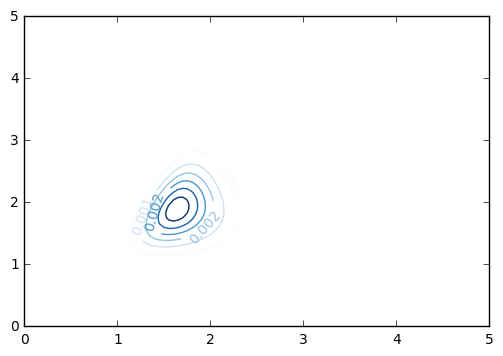

In [6]:
thinkplot.Contour(bulb)

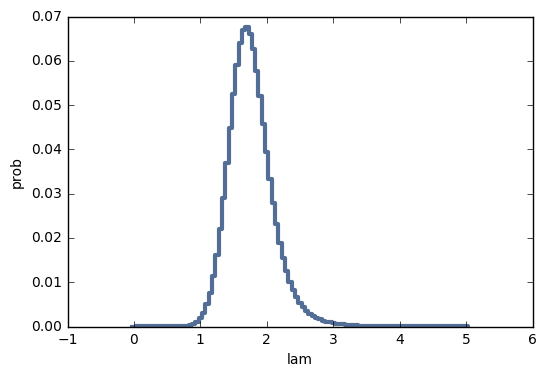

In [7]:
lam_pmf = bulb.Marginal(0)
thinkplot.Pmf(lam_pmf)
thinkplot.Config(xlabel = "lam", ylabel = "prob")

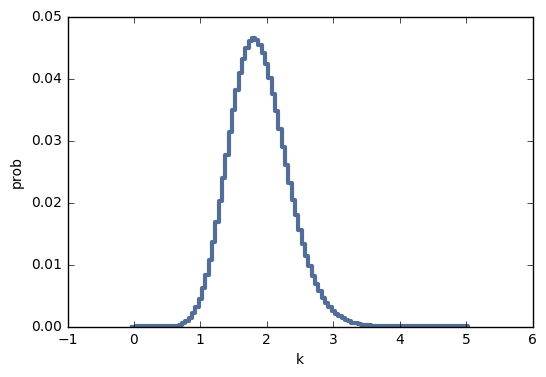

In [8]:
k_pmf = bulb.Marginal(1)
thinkplot.Pmf(k_pmf)
thinkplot.Config(xlabel = "k", ylabel = "prob")

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

To begin this problem, we can set up the init function the same as before. We can also set up the likelihood function similarly except the likelihood is different when lam is not equal to zero. In this case, the likelihood is equal to the area left under the curve of the distribution. To find this, we can evaluate the cumulative distribution function for a Weibull distribution.

In [9]:
class Lightbulb(Suite, Joint):
    def __init__(self, lams, ks):
        
        tups = [(lam, k)
               for lam in lams
               for k in ks]
        Suite.__init__(self, tups)
        
    def Likelihood(self, data, hypo):
        lam, k = hypo
        x = data
        if lam == 0:
            return 0
        
        return 1 - EvalWeibullCdf(x, lam, k)

In [10]:
lams = np.linspace(0,10,101)
ks = np.linspace(0,10,101)

bulb = Lightbulb(lams,ks)
bulb.Update(1)

0.83566549505291376

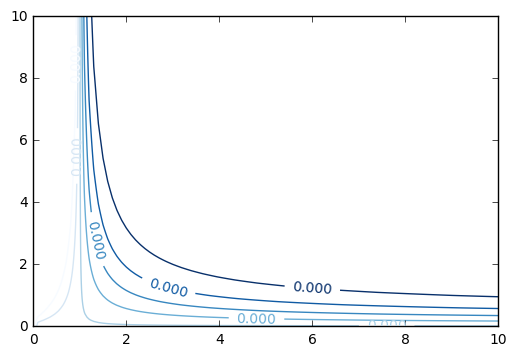

In [11]:
thinkplot.Contour(bulb)

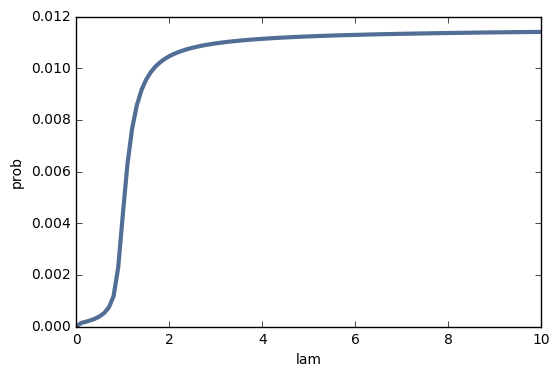

In [12]:
lam_pmf = bulb.Marginal(0)
thinkplot.Pdf(lam_pmf)
thinkplot.Config(xlabel = "lam", ylabel = "prob")

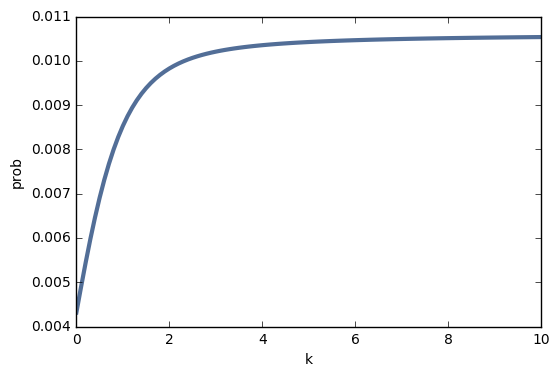

In [13]:
k_pmf = bulb.Marginal(1)
thinkplot.Pdf(k_pmf)
thinkplot.Config(xlabel = "k", ylabel = "prob")

**Exercise:** Now let's put it all together.  Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

`start`: time when the bulb was installed

`lifespan`: lifespan of the bulb in years

`end`: time when bulb died or will die

`age_t`: age of the bulb at t=10

For this problem, we need to split up the likelihood function to return two different values depending on whether the lightbulb died or is still going. If the flag is eq, we need to return the pdf like the first lightbulb problem. If the flag is gt, we need to return the cdf like the problem above.

In [14]:
class Lightbulbs(Suite, Joint):
    def __init__(self, lams, ks):
        tups = [(lam, k)
               for lam in lams
               for k in ks]
        
        Suite.__init__(self, tups)
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        t, x = data
        
        if lam == 0:
            return 0
        
        if t == 'eq':
            like = EvalWeibullPdf(x,lam,k)
        elif t == 'gt':
            like = 1 - EvalWeibullCdf(x,lam,k)
        
        return like

In [15]:
lams = np.linspace(0,10,101)
ks = np.linspace(0,10,101)

bulbs = Lightbulbs(lams,ks)

In [16]:
# From the Survival Notebook
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
df.head()

,lifespan,start,end,age_t
0,0.379063,9.279160,9.658223,0.720840
1,0.723266,2.042419,2.765685,7.957581
2,0.806981,4.006933,4.813914,5.993067
3,0.996672,3.521230,4.517903,6.478770
4,0.942278,2.765804,3.708082,7.234196


We can use the updateset function to update the probability instead of iterating through the data.

In [17]:
bulbs.UpdateSet(data)

5.4748497199046798e-09

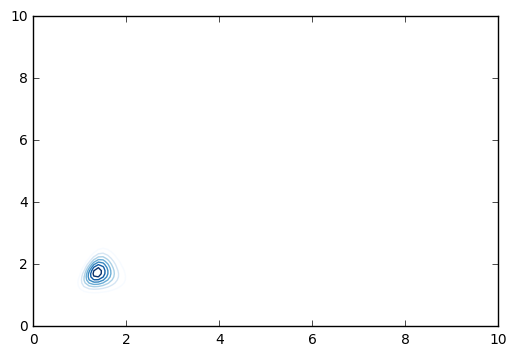

In [18]:
thinkplot.Contour(bulbs)

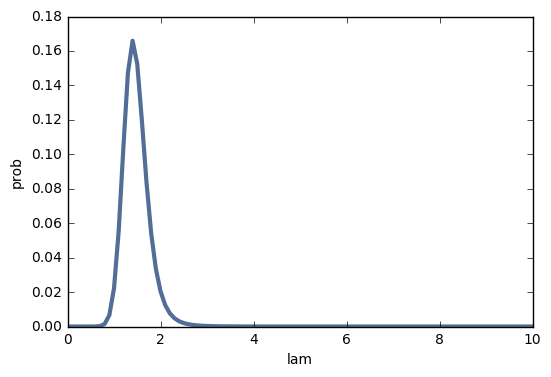

In [19]:
lam_pmf = bulbs.Marginal(0)
thinkplot.Pdf(lam_pmf)
thinkplot.Config(xlabel = "lam", ylabel = "prob")

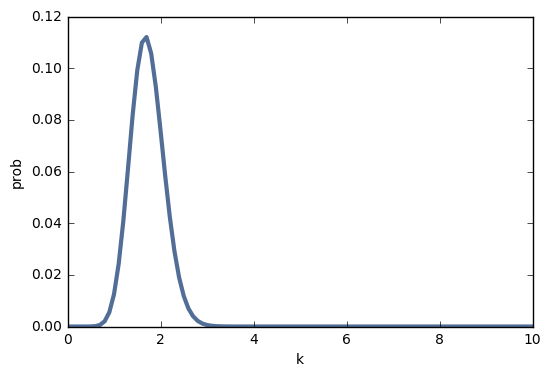

In [20]:
k_pmf = bulbs.Marginal(1)
thinkplot.Pdf(k_pmf)
thinkplot.Config(xlabel = "k", ylabel = "prob")

### The GPS problem
From https://github.com/AllenDowney/ThinkBayes2/blob/master/code/chap09.ipynb


According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

To start, we can define the init function that will take in arrays of x coordinates and y coordinates. The likelihood function will take in an x coordinate and y coordinate as the data. The hypothesis are the defined x coordinate and y coordinates. To find the probability, we can use two normal distributions, one for x and one for y. For evaluating the normal distribution, we can define x as the data, the x coordinate as the mean, and a standard deviation value, which I will use 20.

In [21]:
class GPS(Suite, Joint):
    def __init__(self, coordsx, coordsy):
        coords = [(coordx, coordy)
        for coordx in coordsx
        for coordy in coordsy]
        
        Suite.__init__(self, coords)
        
    def Likelihood(self, data, hypo):
        '''
        data = x,y coordinates
        hypo = hypothesis of x and y coordinates
        
        std_dev is the number of standard deviations
        '''
        coordx, coordy = hypo
        x,y = data
        
        std_dev = 20
        likex = EvalNormalPdf(x, coordx, std_dev)
        likey = EvalNormalPdf(y, coordy, std_dev)
        
        return likex * likey

In [22]:
coords = np.linspace(-100, 100, 201)

gps = GPS(coords, coords)

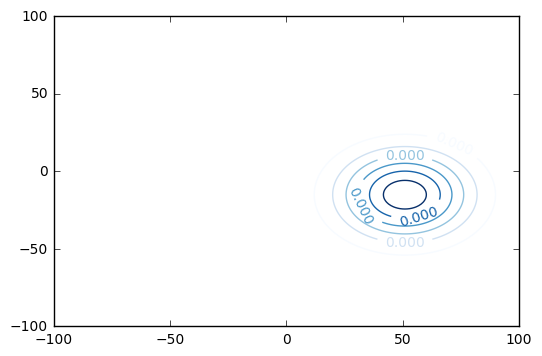

In [23]:
gps.Update((51, -15))
thinkplot.Contour(gps)

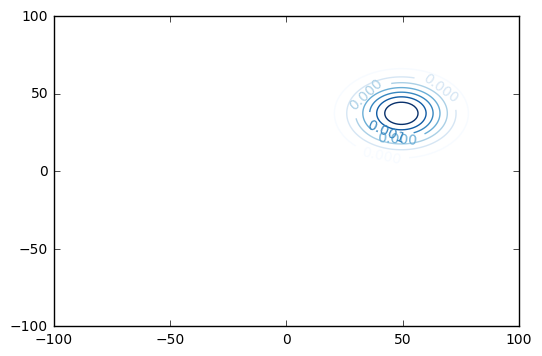

In [24]:
gps.Update((48, 90))
thinkplot.Contour(gps)

In [25]:
coordinates = [(11.903060613102866, 19.79168669735705),
    (77.10743601503178, 39.87062906535289),
    (80.16596823095534, -12.797927542984425),
    (67.38157493119053, 83.52841028148538),
    (89.43965206875271, 20.52141889230797),
    (58.794021026248245, 30.23054016065644),
    (2.5844401241265302, 51.012041625783766),
    (45.58108994142448, 3.5718287379754585)]

gps.UpdateSet(coordinates)

6.4604355356653435e-36

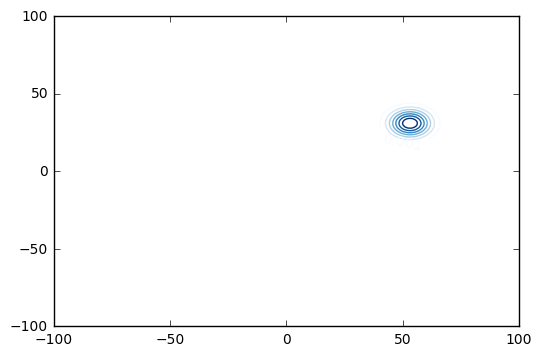

In [26]:
thinkplot.Contour(gps)

In [27]:
pmf_x = gps.Marginal(0)
pmf_y = gps.Marginal(1)

print('Mean of x: ', pmf_x.Mean(), ' Standard deviation of x: ', pmf_x.Std())
print('Mean of y: ', pmf_y.Mean(), ' Standard deviation of y: ', pmf_y.Std())

Mean of x:  53.1957242951  Standard deviation of x:  6.32455532033042
Mean of y:  31.0728627918  Standard deviation of y:  6.324555320336777
